In [55]:
# Run on GPU server
# import os
# os.chdir('/root/autodl-tmp/FinanceTech/')

In [56]:
import pickle
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import DataLoader, Dataset
from codes.nn_utils import *
from codes.loss import weight_ic_loss, ic_loss
from codes.backtest import backtest, show_back_test
from tqdm import tqdm
import matplotlib.pyplot as plt

In [57]:
with open("factors/factor_df_list.pkl", "rb") as f:
    X = pickle.load(f)
with open("factors/y.pkl", "rb") as f:
    y = pickle.load(f)
print(len(X), " ", X[0].shape)
print(y.shape)

100   (1369, 503)
(1369, 503)


In [58]:
# 数据清洗
X, y = fill_na(X, y)

In [59]:
# 将X和y转为Tensor
X = convert_to_tensor(X)
y = torch.Tensor(y.values)
print(type(X), " : ", X.shape)
print(type(y), " : ", y.shape)

<class 'torch.Tensor'>  :  torch.Size([1369, 503, 100])
<class 'torch.Tensor'>  :  torch.Size([1369, 503])


In [60]:
X = X.double()
y = y.double()
print(X.isnan().any())
print(X.isinf().any())
print(y.isnan().any())
print(y.isinf().any())

tensor(False)
tensor(False)
tensor(False)
tensor(False)


In [61]:
def std_(X):
    # 假设你的输入数据为 input_data，它的形状为 [1369, 503, 100]

    mean = torch.mean(X, dim=0, keepdim=True)  # 计算每个因子的每个股票的时间序列的均值
    std = torch.std(X, dim=0, keepdim=True)  # 计算每个因子的每个股票的时间序列的标准差

    # 对数据进行标准化
    X = (X - mean) / (std + 1e-6)  # 为防止除以零，我们添加了一个小的正数 1e-6
    return X
X = std_(X)


In [62]:
# 分割数据
# 根据train, test, val的比例分割数据集
train_prop = 0.6
test_prop = 0.2
val_prop = 0.2
train_X, train_y, test_X, test_y , val_X , val_y = split_train_test_val(X, y, train_prop, test_prop, val_prop)
print(f"train_X : {type(train_X)}, {train_X.shape}")
print(f"train_y : {type(train_y)}, {train_y.shape}")
print(f"test_X : {type(test_X)}, {test_X.shape}")
print(f"test_y : {type(test_y)}, {test_y.shape}")
print(f"val_X : {type(val_X)}, {val_X.shape}")
print(f"val_y : {type(val_y)}, {val_y.shape}")

train_X : <class 'torch.Tensor'>, torch.Size([1369, 503, 100])
train_y : <class 'torch.Tensor'>, torch.Size([1369, 503])
test_X : <class 'torch.Tensor'>, torch.Size([274, 503, 100])
test_y : <class 'torch.Tensor'>, torch.Size([274, 503])
val_X : <class 'torch.Tensor'>, torch.Size([274, 503, 100])
val_y : <class 'torch.Tensor'>, torch.Size([274, 503])


In [63]:
class GRUDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor, days: int):
        super(GRUDataset, self).__init__()
        self.X = X
        self.y = y
        self.days = days
        assert len(self.X) == len(self.y)

    def __getitem__(self, index):
        if index > len(self.X) - self.days:
            raise ValueError("Index should be greater or equal to 'days'")

        X = torch.Tensor(self.X[index:index+self.days])
        y = torch.Tensor(self.y[index+self.days])
        return X, y

    def __len__(self):
        # 减去 'days'，因为前 'days' 天的数据不能作为一个完整的输入
        return len(self.X) - self.days

In [64]:
class GRU(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, output_size: int, num_layers: int, dropout: float):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=False, dropout=dropout, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        X, _ = self.gru(X)
        X = self.output_layer(X[-1])  # 获取最后一天的隐藏状态
        return X

In [65]:
# 设置随机数种子
setup_seed(1)

In [66]:
show_cuda_info()

Cuda is available :  True
Cuda num :  1
Current cuda index :  0
Current cuda name :  NVIDIA GeForce RTX 4090


# 准备数据集

In [67]:
days = 20
train_dataset = GRUDataset(X=train_X, y=train_y, days=days)
test_dataset = GRUDataset(X=test_X, y=test_y, days=days)
val_dataset = GRUDataset(X=val_X, y=val_y, days=days)

In [68]:
# 准备训练参数

In [69]:
gru_loss_list = []
val_loss_list = []
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

gru = GRU(input_size=100, hidden_size=128, output_size=1, dropout=0.1, num_layers=3)
gru.to(device)
gru = gru.double()
gru.apply(init_weights)

gru_epoch_size = 30
gru_lr = 0.00001
gru_batch_size = 1
# gru_loss_func = weight_ic_loss
gru_loss_func = ic_loss
# gru_loss_func = nn.Loss
gru_optimizer = torch.optim.Adam(gru.parameters(), lr=gru_lr)

In [70]:
# 包装成DataLoader
train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=gru_batch_size)  # 是否可以shuffle？
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=gru_batch_size)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=gru_batch_size)

In [71]:
# 训练模型

In [72]:
for epoch in tqdm(range(gru_epoch_size)):
    # 训练
    gru.train()
    epoch_train_loss = []  # 每个epoch开始时重置训练损失列表
    for X, y in train_dataloader:
        gru_optimizer.zero_grad()
        X = X.squeeze()
        y = y.squeeze()
        y_pred = gru(X.to(device))
        loss = gru_loss_func(y_pred=y_pred.squeeze(), y=y.to(device))
        epoch_train_loss.append(loss.detach().cpu().item())
        loss.backward()
        clip_grad_norm(gru, 1.)
        gru_optimizer.step()
    gru_loss_list.append(np.mean(epoch_train_loss))  # 计算并记录每个epoch的平均训练损失

    # 测试
    gru.eval()
    epoch_val_loss = []  # 每个epoch开始时重置验证损失列表
    with torch.no_grad():
        for X_val, y_val in val_dataloader:
            y_val_pred = gru(X_val.to(device).squeeze())
            val_loss = gru_loss_func(y_pred=y_val_pred.squeeze(), y=y_val.to(device).squeeze())
            epoch_val_loss.append(val_loss.detach().cpu().item())
    val_loss_list.append(np.mean(epoch_val_loss))  # 计算并记录每个epoch的平均验证损失

100%|██████████| 30/30 [18:30<00:00, 37.00s/it]


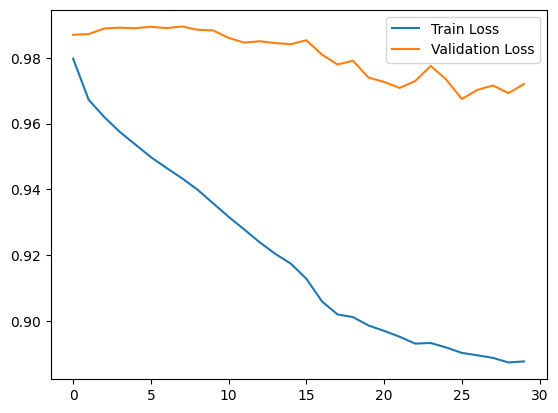

In [73]:
plt.plot(gru_loss_list, label='Train Loss')
plt.plot(val_loss_list, label='Validation Loss') # 新增，画出验证集的损失曲线
plt.legend() # 新增，显示图例
plt.show()

In [74]:
# torch.save(gru, "models/gru.pth")

In [75]:
gru = torch.load("models/gru.pth")

In [76]:
def get_predictions(model, dataloader, device):
    model.eval()  # 设置模型为评估模式
    predictions = []

    with torch.no_grad():  # 关闭梯度计算
        for X, _ in tqdm(dataloader):  # 我们只关心输入数据，不需要标签
            X = X.to(device).squeeze()
            y_pred = model(X)
            # print(y_pred.transpose(1, 0).shape)
            # raise
            predictions.append(y_pred.transpose(1, 0).cpu().numpy())  # 转换为numpy数组并添加到列表中

    predictions = np.concatenate(predictions, axis=0)  # 将所有预测结果拼接到一起
    return predictions

In [77]:
# 获取各个数据集上的预测结果
train_predictions = get_predictions(gru, train_dataloader, device)
test_predictions = get_predictions(gru, test_dataloader, device)
val_predictions = get_predictions(gru, val_dataloader, device)
print(f"train_predictions: {train_predictions.shape}")
print(f"test_predictions: {test_predictions.shape}")
print(f"val_predictions: {val_predictions.shape}")

100%|██████████| 254/254 [00:02<00:00, 109.55it/s]

train_predictions: (1349, 503)
test_predictions: (254, 503)
val_predictions: (254, 503)


In [78]:
# 保存预测结果
np.save("data/train_predictions.npy", train_predictions)
np.save("data/test_predictions.npy", test_predictions)
np.save("data/val_predictions.npy", val_predictions)

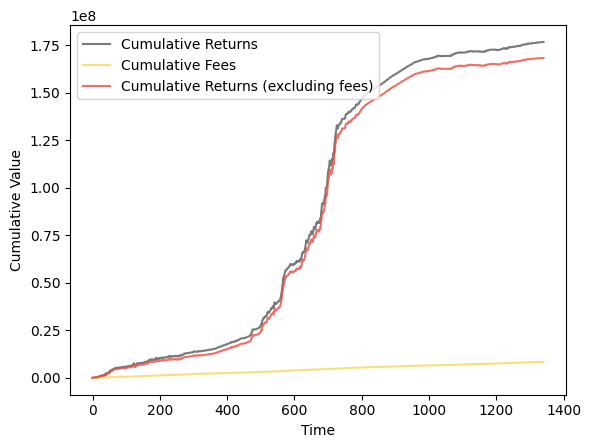

returns    : 1.5804         
ir         : 0.3288         
sharpe     : 5.2194         
turnover   : 0.1572         
draw_down  : 5599308.4205   


In [79]:
show_back_test(train_y.numpy(), train_predictions, decay=8)

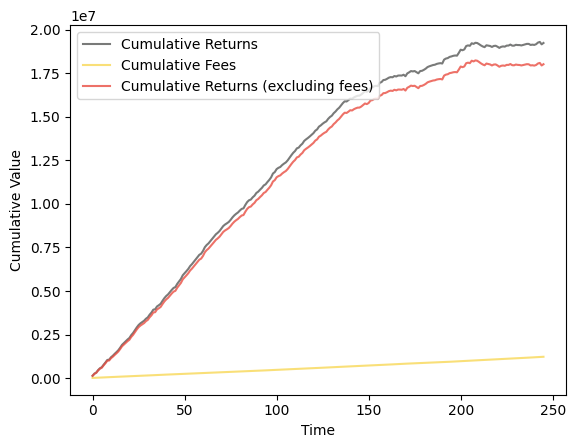

returns    : 0.9233         
ir         : 1.1130         
sharpe     : 17.6688        
turnover   : 0.1240         
draw_down  : 364476.7437    


In [80]:
show_back_test(test_y.numpy(), test_predictions, decay=8)

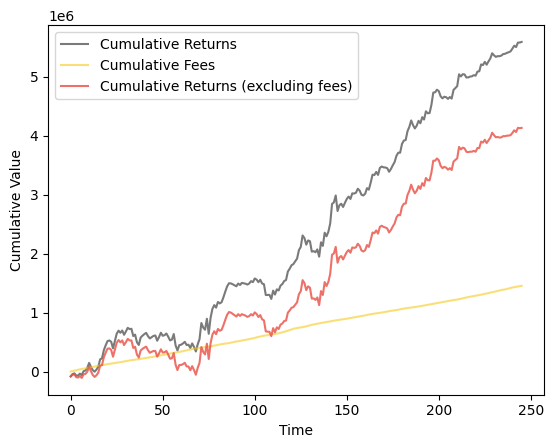

returns    : 0.2116         
ir         : 0.2094         
sharpe     : 3.3237         
turnover   : 0.1480         
draw_down  : 593205.6576    


In [81]:
show_back_test(val_y.numpy(), val_predictions, decay=8)